In [1]:
import os
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [2]:
# parameters
device = pt.device("cpu")

# model parameters
save_path = "model/save/s_v6_4_2022-09-16_11-51"  # virtual Cb & partial

# create models
model = rt.SequenceModel(save_path, "model.pt", device=device)

# create confidence mapping
conf = rt.ConfidenceMap("results/{}_cdf.csv".format(os.path.basename(save_path)))

In [3]:
# parameters
structure = rt.load_structure("pdbs/1zns_ref_dna.pdb")
#structure = rt.load_structure("pdbs/1zns_2ivh_dna.pdb")
structure['chain_name'] = np.array([str(cid) for cid in structure['cid']])

In [4]:
def scoring(p, y):
    # compute confidence probability
    c = pt.from_numpy(conf(p.numpy()))

    # get sequence
    seq_ref = rt.max_pred_to_seq(y)
    seq = rt.max_pred_to_seq(c)

    # assess predictions
    return {
        "size": p.shape[0],
        "recovery_rate": rt.recovery_rate(y, c).numpy().item(),
        "sequence_similarity": rt.sequence_similarity(seq_ref, seq),
        "maximum_recovery_rate": rt.maximum_recovery_rate(y, p).numpy().item(),
        "average_multiplicity": rt.average_multiplicity(p).numpy().item(),
        "average_maximum_confidence": rt.average_maximum_confidence(p).numpy().item(),
        "average_maximum_score": rt.average_maximum_confidence(c).numpy().item(),
    }

In [5]:
# parameters
pdbid_sel = "1ZNS"
#pdbid_sel = "1BT5"
#d_thr = 4.0  # dna
d_thr = 3.0  # ion
b_Zn_to_Ca = True 

if b_Zn_to_Ca:
    # hard swich Zn to Ca
    ik = np.where(structure['element'] == 'Zn')[0].item()
    structure['element'][ik] = "Ca"
    structure['resname'][ik] = "CA"
    structure['name'][ik] = "CA"

# molecule type and discard unclassified
subunits = sp.split_by_chain(structure)
sub_types = rt.subunits_type(subunits)
subunits = {cid:subunits[cid] for cid in [st[1] for st in sub_types if st[0] != 'na']}
#subunits = {cid:subunits[cid] for cid in [st[1] for st in sub_types if st[0] != 'ligand']}
structure = sp.concatenate_chains(subunits)

# find proteins subunits and residue to chain mapping
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']

# apply model on full structure
_, p, y = model(structure)

# prediction split by chain
rcids = np.array([res['chain_name'][0] for res in sp.split_by_residue(structure)])
pr = {cid:p[rcids==cid] for cid in cids_prot}
yr = {cid:y[rcids==cid] for cid in cids_prot}

# apply model with binder subunits known
pc, yc = {}, {}
for cid in cids_prot:
    m_known = (structure['chain_name'] != cid)
    _, pi, yi = model(structure, m_known=m_known)
    pi = pi[rcids==cid]
    yi = yi[rcids==cid]
    pi, yi = rt.aa_only(pi, yi)
    pc[cid] = pi
    yc[cid] = yi

# apply model to subunits alone
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']
ps, ys = {}, {}
for cid in cids_prot:
    subunit = subunits[cid]
    subunit['chain_name'] = np.array([cid]*subunit['xyz'].shape[0])
    if len(np.unique(subunit['resid'])) >= model.module.config_data['min_num_res']:
        _, pi, yi = model(subunit)
        pi, yi = rt.aa_only(pi, yi)
        ps[cid] = pi
        ys[cid] = yi
        
# check that labels match perfectly
for cid in ys:
    assert pt.sum(pt.abs(yc[cid] - ys[cid])).long().item() == 0

# contacts
contacts = sp.extract_all_contacts(subunits, d_thr, device=device)

# analyse interface recovery
results = []
interfaces = {}
for cid in cids_prot:
    # checks
    if (cid in contacts) and (cid in ys):
        for cidb in sorted(list(contacts[cid])):
            # atom-atom contacts indices
            ctc_ids = contacts[cid][cidb]['ids'][:,0]

            # convert to residue-residue contacts indices
            _, ids = pt.unique(pt.from_numpy(subunits[cid]['resid']), return_inverse=True)
            ctc_rids = pt.unique(ids[ctc_ids])

            ids_rctc = np.argmax((subunits[cid]['resid'].reshape(-1,1) == np.unique(subunits[cid]['resid'][np.unique(ctc_ids)])).astype(float), axis=0)
            rctc_seq = np.array([sp.res3to1[rn] for rn in subunits[cid]['resname'][ids_rctc]])
            
            # binder type
            btype = [st[0] for st in sub_types if st[1] == cidb][0]

            # scoring with context
            results.append({'context_level': 2, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(pc[cid][ctc_rids], yc[cid][ctc_rids]))
            
            # scoring with context
            results.append({'context_level': 1, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(pr[cid][ctc_rids], yr[cid][ctc_rids]))
            
            # scoring without context
            results.append({'context_level': 0, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(ps[cid][ctc_rids], ys[cid][ctc_rids]))

            y0 = pt.max(ps[cid][ctc_rids] * ys[cid][ctc_rids], dim=1)[0].numpy()
            y1 = pt.max(pr[cid][ctc_rids] * yr[cid][ctc_rids], dim=1)[0].numpy()
            p0 = pt.max(ps[cid][ctc_rids], dim=1)[0].numpy()
            p1 = pt.max(pr[cid][ctc_rids], dim=1)[0].numpy()
            c0 = pt.max(pt.from_numpy(conf(ps[cid][ctc_rids].numpy())) * ys[cid][ctc_rids], dim=1)[0].numpy()
            c1 = pt.max(pt.from_numpy(conf(pr[cid][ctc_rids].numpy())) * yr[cid][ctc_rids], dim=1)[0].numpy()

            x = np.arange(y0.shape[0])
            if btype in interfaces:
                interfaces[btype][0] = np.concatenate([interfaces[btype][0], ctc_rids])
                interfaces[btype][1] = np.concatenate([interfaces[btype][1], y0])
                interfaces[btype][2] = np.concatenate([interfaces[btype][2], y1])
                interfaces[btype][3] = np.concatenate([interfaces[btype][3], p0])
                interfaces[btype][4] = np.concatenate([interfaces[btype][4], p1])
                interfaces[btype][5] = np.concatenate([interfaces[btype][5], c0])
                interfaces[btype][6] = np.concatenate([interfaces[btype][6], c1])
                interfaces[btype][7] = np.concatenate([interfaces[btype][7], rctc_seq])
            else:
                interfaces[btype] = [ctc_rids.numpy(), y0, y1, p0, p1, c0, c1, rctc_seq]

In [6]:
# store results with interface location
m_int = pt.zeros(pc['0'].shape[0], dtype=pt.bool)
rids_int = np.unique(np.concatenate([interfaces[itype][0] for itype in interfaces]))
m_int[rids_int] = True

# save to file
pt.save({'ps': ps['0'], 'pc': pc['0'], 'y': ys['0'], 'm_int': m_int}, "results/cole7/output.pt")

In [7]:
rt.recovery_rate(ys['0'], ps['0']), rt.recovery_rate(yc['0'], pc['0'])

(tensor(0.4831), tensor(0.4746))

In [8]:
rt.recovery_rate(ys['0'][m_int], ps['0'][m_int]), rt.recovery_rate(yc['0'][m_int], pc['0'][m_int])

(tensor(0.4000), tensor(0.5000))

In [9]:
list(interfaces)

['ion', 'dna']

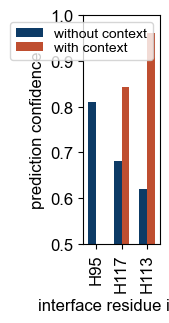

{'recovery_rate_without_context': 0.3333333333333333,
 'recovery_rate_with_context': 0.3333333333333333,
 'maximum_recovery_rate_without_context': 1.0,
 'maximum_recovery_rate_with_context': 0.6666666666666666}

In [10]:
# parameters
ws = 0.3
#itype = "dna"
itype = "ion"

# extract data
v, y0, y1, p0, p1, c0, c1, rn = interfaces[itype]

# remove duplicated
idx = np.sort(np.unique(v, return_index=True)[1])
v = v[idx]
rn = rn[idx]
y0 = y0[idx]
y1 = y1[idx]
p0 = p0[idx]
p1 = p1[idx]

#m0 = ((y0 < 0.5) & (y1 > 0.5)).astype(float)
#m1 = (y0 < y1).astype(float)
#ids = np.argsort(2*y1-p1 + (y1-y0) + (p1 == y1).astype(float))
ids = np.argsort(np.maximum(y0, y1))
v = v[ids]
rn = rn[ids]
y0 = y0[ids]
y1 = y1[ids]
p0 = p0[ids]
p1 = p1[ids]
x = np.arange(v.shape[0])

# plot
#plt.figure(figsize=(10,2.4))
#plt.figure(figsize=(3,2.4))
#plt.figure(figsize=(1+0.3*v.shape[0],2.4))
#plt.figure(figsize=(1+0.3*v.shape[0],3.4))
plt.figure(figsize=(1+0.22*v.shape[0],3.4))
#plt.bar(x-0.5*ws, p0, width=ws, color=colors[3], alpha=0.5)
plt.bar(x-0.5*ws, y0, width=ws, color=colors[1], label="without context")
#plt.bar(x+0.5*ws, p1, width=ws, color=colors[3], alpha=0.5)
plt.bar(x+0.5*ws, y1, width=ws, color=colors[0], label="with context")
#for i in range(p0.shape[0]):
#    plt.plot([x[i]-ws*0.9, x[i]-0.1*ws], [p0[i], p0[i]], 'k-', alpha=0.5)
#    plt.plot([x[i]+ws*0.1, x[i]+0.9*ws], [p1[i], p1[i]], 'k-', alpha=0.5)
#plt.plot([-0.5, len(x)-0.5], [0.5, 0.5], 'k-', alpha=0.5)
#plt.xticks(x, v+1)
plt.xticks(x, [n+str(i) for n,i in zip(rn,v+1)], fontsize=12, weight='normal', rotation=90)
plt.yticks(np.linspace(0.5, 1.0, 6), np.linspace(0.5, 1.0, 6))
plt.xlim(-0.5, len(x)-0.5)
plt.ylim(0.5, 1.0)
plt.legend(loc='best', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('interface residue index')
plt.ylabel('prediction confidence')
plt.tight_layout()
if b_Zn_to_Ca:
    plt.savefig("graphs/{}_{}_mod_Ca_interface_prediction.svg".format(pdbid_sel, itype))
else:
    plt.savefig("graphs/{}_{}_interface_prediction.svg".format(pdbid_sel, itype))
plt.show()

# save statistics
summary = {
    'recovery_rate_without_context': np.mean(p0 == y0),
    'recovery_rate_with_context': np.mean(p1 == y1),
    'maximum_recovery_rate_without_context': np.mean(y0 >= 0.5),
    'maximum_recovery_rate_with_context': np.mean(y1 >= 0.5),
}
if b_Zn_to_Ca:
    json.dump(summary, open("results/{}_{}_mod_Ca_interface_prediction.json".format(pdbid_sel, itype), 'w'))
else:
    json.dump(summary, open("results/{}_{}_interface_prediction.json".format(pdbid_sel, itype), 'w'))
summary

<Axes: xlabel='element'>

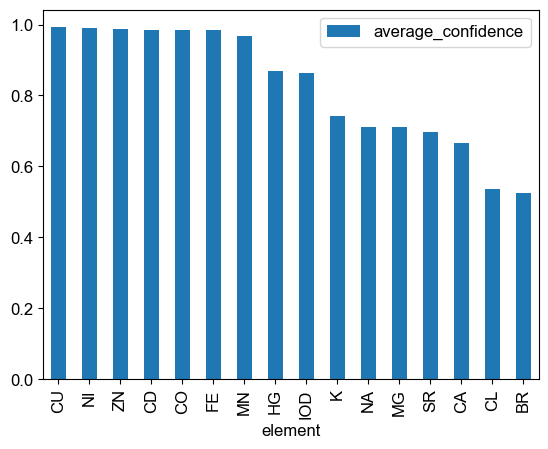

In [11]:
pd.DataFrame([
    ('MG', 0.70997334),
    ('ZN', 0.9878375),
    ('CL', 0.5378498),
    ('CA', 0.6672906),
    ('NA', 0.7124161),
    ('MN', 0.96890736),
    ('K', 0.74348897),
    ('IOD', 0.86407775),
    ('CD', 0.9856343),
    ('CU', 0.9920692),
    ('FE', 0.9851079),
    ('NI', 0.98902875),
    ('SR', 0.6977055),
    ('BR', 0.5261112),
    ('CO', 0.98525363),
    ('HG', 0.86989146),
], columns=['element', 'average_confidence']).sort_values("average_confidence", ascending=False).plot.bar('element')